In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import time

In [2]:
data = pd.read_csv('C:\\Users\\Noman\\Desktop\\cowlar task 1\\data\\fea.csv', header=None)

def analyze_correlations(data):
    # Calculate the covariance matrix
    cov_matrix = np.cov(data, rowvar=False)

    # Get the off-diagonal elements
    off_diagonal = cov_matrix[~np.eye(cov_matrix.shape[0], dtype=bool)]

    # Check for correlations
    uncorrelated = np.isclose(off_diagonal, 0, atol=0.01).sum()
    positively_correlated = (off_diagonal > 0.01).sum()
    negatively_correlated = (off_diagonal < -0.01).sum()

    print(f"There are {uncorrelated} pairs of variables that are uncorrelated.")
    print(f"There are {positively_correlated} pairs of variables that are positively correlated.")
    print(f"There are {negatively_correlated} pairs of variables that are negatively correlated.")
    return cov_matrix

In [3]:
def plot_cov_matrix(data, title='Covariance Matrix Heatmap'):
    cov_matrix = analyze_correlations(data)
    plt.figure(figsize=(10,10))
    sns.heatmap(cov_matrix, cmap='coolwarm', center=0)
    plt.title(title)
    plt.show()

In [4]:
def calc_n_components(data, variance=0.99):
    # Initialize a PCA model with a variance that explains 95% of the variance
    pca = PCA(n_components=variance)
    pca.fit(data)
    print(f"{pca.n_components_} components explain {variance} of the variance.")
    print("\n")
    return pca.n_components_

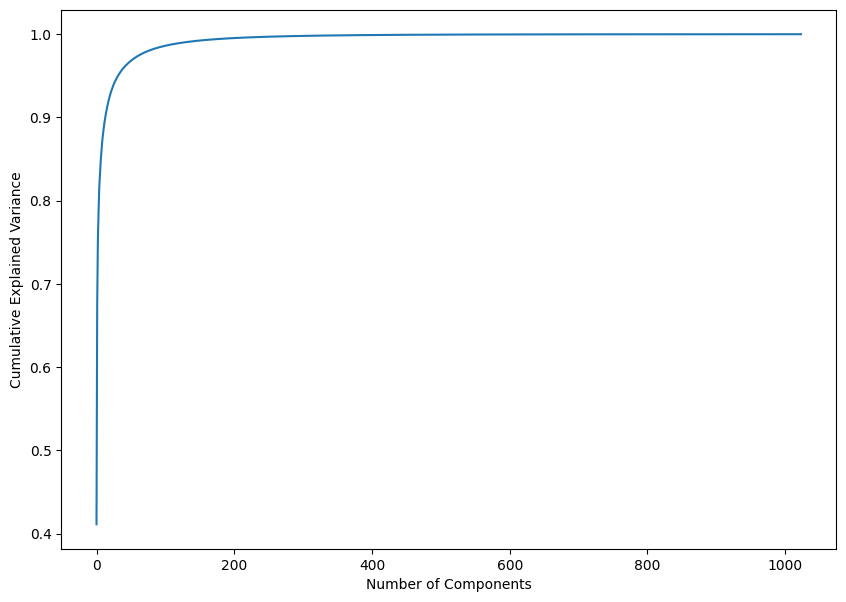

In [5]:
# Code to plot the cumulative explained variance as a function of the number of components, this code is redundant and is only used in the notebook to show the process of selecting the number of components
pca = PCA(n_components=None)
pca.fit(data) 

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance ratios
plt.figure(figsize=(10, 7))
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

There are 6 pairs of variables that are uncorrelated.
There are 906580 pairs of variables that are positively correlated.
There are 140966 pairs of variables that are negatively correlated.


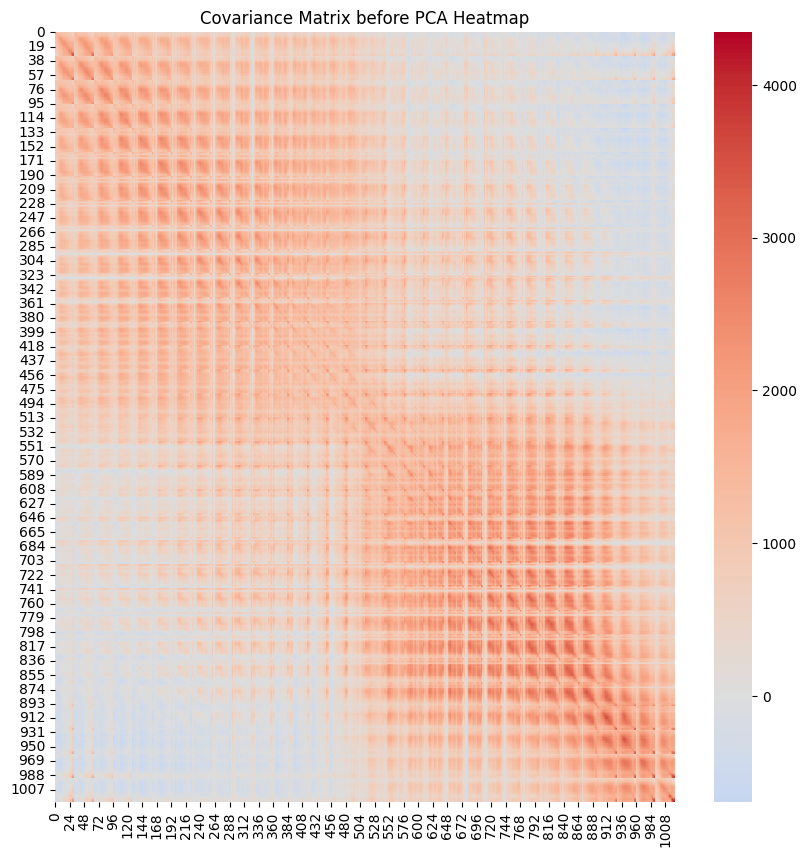

127 components explain 0.99 of the variance.


There are 16002 pairs of variables that are uncorrelated.
There are 0 pairs of variables that are positively correlated.
There are 0 pairs of variables that are negatively correlated.


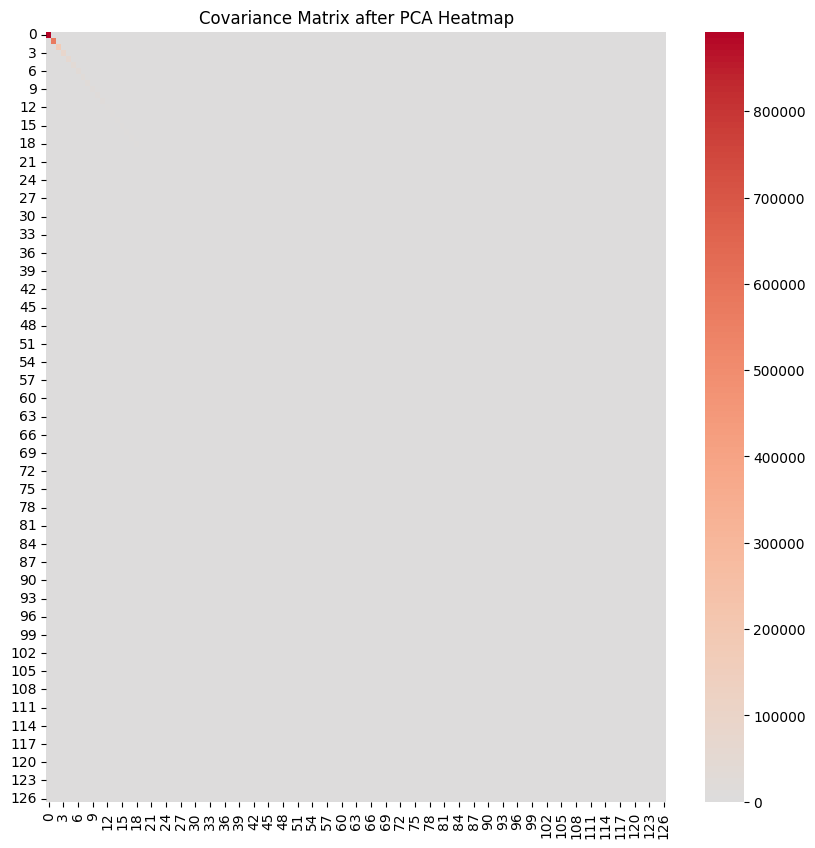

In [6]:
plot_cov_matrix(data, title='Covariance Matrix before PCA Heatmap')

n_components_99_percent = calc_n_components(data, 0.99)

# Initialize a PCA model with a variance that explains 99% of the variance
pca = PCA(n_components=n_components_99_percent)
data_array = pca.fit_transform(data)
data = pd.DataFrame(data_array)

plot_cov_matrix(data, title='Covariance Matrix after PCA Heatmap')


In [7]:
# Constants
examples_per_label = 170
num_splits = 5

def create_df(dataframe, num_labels):
    """Create a dataframe with a specified number of labels."""
    labels = np.repeat(np.arange(num_labels), examples_per_label)
    dataframe = dataframe.iloc[:num_labels*examples_per_label]
    return dataframe, labels

In [8]:
def normalize_data(truncated_dataframe):
    """Normalize the data in the dataframe."""
    normalized_data_array = truncated_dataframe.values / np.linalg.norm(truncated_dataframe.values, axis=1, keepdims=True)
    norms = np.linalg.norm(normalized_data_array, axis=1, keepdims=True)
    assert np.all(np.isclose(norms, 1.0))
    return pd.DataFrame(normalized_data_array, columns=truncated_dataframe.columns)

In [9]:
def create_data_splits(normalized_data_dataframe, num_labels, train_rows, test_rows, num_splits):
    """Create data splits for training and testing."""
    train_dfs_list = []
    test_dfs_list = []
    for i in range(num_splits):
        train_data = []
        test_data = []
        for label in range(num_labels):
            label_data = normalized_data_dataframe[normalized_data_dataframe['label'] == label].copy()
            train_label_data, test_label_data = train_test_split(label_data, train_size=train_rows, test_size=test_rows, random_state=i)
            train_data.append(train_label_data)
            test_data.append(test_label_data)
        train_dfs_list.append(pd.concat(train_data).sample(frac=1.0, random_state=i).reset_index(drop=True))
        test_dfs_list.append(pd.concat(test_data).sample(frac=1.0, random_state=i).reset_index(drop=True))
    return train_dfs_list, test_dfs_list

In [10]:
def process_data(num_labels, train_rows, test_rows):
    truncated_df, labels = create_df(data, num_labels)
    normalized_data_df = normalize_data(truncated_df)
    normalized_data_df['label'] = labels
    return create_data_splits(normalized_data_df, num_labels, train_rows, test_rows, num_splits)

In [11]:
def extract_features_and_labels(dfs_list):
    X = [df.drop('label', axis=1).values for df in dfs_list]
    y = [df['label'].values for df in dfs_list]
    return X, y

In [12]:
labels_list = [10,7,5]
train_test_pairs = [(150, 20), (100, 70)]
train_test_dfs = [process_data(num_labels, train_rows, test_rows) for num_labels in labels_list for train_rows, test_rows in train_test_pairs]
train_dfs_all, test_dfs_all = zip(*train_test_dfs)
X_train_all, y_train_all = zip(*[extract_features_and_labels(train_dfs_list) for train_dfs_list in train_dfs_all])
X_test_all, y_test_all = zip(*[extract_features_and_labels(test_dfs_list) for test_dfs_list in test_dfs_all])

In [13]:
import os
os.chdir('..')

In [14]:
from src.knn import KNNClassifier


# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=["k_value", "distance_algo", "number_of_labels", "training_test_pair", "average_accuracy", "std_accuracy", "computation_time"])

for current_k in [3,5,7,9,11]:
    for distance in ['euclidean', 'manhattan', 'cosine']:
        knn_model = KNNClassifier(k=current_k, distance=distance)
        print(f'Results using k = {current_k} and distance measure of {distance}:')
        count = 0
        for X_train_splits, y_train_splits, X_test_splits, y_test_splits in zip(X_train_all, y_train_all, X_test_all, y_test_all):
            if count % 2 == 0:
                current_label = labels_list[count//2]
            current_training_examples, current_testing_values = train_test_pairs[count%2]
            count += 1
            accuracy_list = []
            start_time = time.time()
            for X_train, y_train, X_test, y_test in zip(X_train_splits, y_train_splits, X_test_splits, y_test_splits):
                knn_model.fit(X_train, y_train)
                y_pred = knn_model.predict(X_test)
                accuracy_list.append(np.mean(y_pred == y_test))
            end_time = time.time()
            computation_time = end_time - start_time
            print(computation_time)
            average_accuracy = np.mean(accuracy_list)
            std_accuracy = np.std(accuracy_list)
            print(f'Using {current_label} labels, {current_training_examples} training examples and {current_testing_values} test cases PER SUBJECT over 5 random splits:')
            print(f'Average accuracy: {average_accuracy:.3f}                           Standard deviation over accuracy: {std_accuracy:.3f}')
            print('------------------------------------------------------------------------------------------')
            
            # Append the results to the DataFrame
            results_to_append = pd.DataFrame({
                "k_value": [current_k],
                "distance_algo": [distance],
                "number_of_labels": [current_label],
                "training_test_pair": [f"{current_training_examples}_{current_testing_values}"],
                "average_accuracy": [average_accuracy],
                "std_accuracy": [std_accuracy],
                "computation_time": [computation_time]
            })
            results_df = pd.concat([results_df, results_to_append], ignore_index=True)
            
        print('==========================================================================================')
    print('==========================================================================================')
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print('==========================================================================================')

# Save the DataFrame to a CSV file
results_df.to_csv("knn_results_pca.csv", index=False)


Results using k = 3 and distance measure of euclidean:
1.482039451599121
Using 10 labels, 150 training examples and 20 test cases PER SUBJECT over 5 random splits:
Average accuracy: 0.969                           Standard deviation over accuracy: 0.030
------------------------------------------------------------------------------------------
4.0913941860198975
Using 10 labels, 100 training examples and 70 test cases PER SUBJECT over 5 random splits:
Average accuracy: 0.951                           Standard deviation over accuracy: 0.011
------------------------------------------------------------------------------------------
0.9510326385498047
Using 7 labels, 150 training examples and 20 test cases PER SUBJECT over 5 random splits:
Average accuracy: 0.970                           Standard deviation over accuracy: 0.031
------------------------------------------------------------------------------------------
2.0344600677490234
Using 7 labels, 100 training examples and 70 test cases